# Progetto Machine Learning: language identification

### Load libraries

In [31]:
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import string
import collections
import pickle
import seaborn as sns

## Parsing functions

### Text to feature vector

In [32]:
def parse_string(word, lang = None):
    str(word)
    word = strip_accents(word.lower())
    length = len(word)
    LetterFreq={}
    for letter in string.ascii_lowercase:
        LetterFreq[letter] = 0
    for letter in word.lower():
        LetterFreq[letter] += 1
    features = list(LetterFreq.values())
    if(length > 0):
        features = [float(x) for x in features]
#        features = [float(x)/length for x in features]

    
#    features.append(length)
    
    if(lang != None):
        features.append(lang)
    
    return features

### Removing accents

In [33]:
def strip_accents(word):
    table = collections.defaultdict(lambda: None)
    table.update({
        ord('é'): 'e',
        ord('ô'): 'o',
        ord('è'): 'e',
        ord('à'): 'a',
        ord('ì'): 'i',
        ord('ù'): 'u',
        ord('\n'): '',
    })
    table.update(dict(zip(map(ord,string.ascii_uppercase), string.ascii_lowercase)))
    table.update(dict(zip(map(ord,string.ascii_lowercase), string.ascii_lowercase)))
    table.update(dict(zip(map(ord,string.digits), string.digits)))
    return word.translate(table,)

## Model selection

### Load dataset

In [34]:
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
         'U', 'V', 'W','X', 'Y', 'Z', 'class']

dataset_it = DataFrame((parse_string(word,'Italian') for word in open('./Data/italian.txt', encoding = "ISO-8859-1")), columns = names)
dataset_en = DataFrame(([parse_string(word,'English') for word in open('./Data/english.txt', encoding = "ISO-8859-1")]), columns=names)
dataset_zh = DataFrame(([parse_string(word,'Chinese') for word in open('./Data/chinese.txt', encoding = "ISO-8859-1")]) , columns = names)

In [35]:
dataset = DataFrame()
dataset = dataset.append(dataset_it)
dataset = dataset.append(dataset_en)
dataset = dataset.append(dataset_zh)

### Split-out validation dataset


In [36]:
array = dataset.values
X = array[:,0:26]
Y = array[:,26]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=validation_size, random_state=seed)

### Spot-Check Algorithms

In [103]:
models=[]
models.append(('LR', LogisticRegression(multi_class='auto', solver='liblinear')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('MLP', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(30,10), random_state=3)))

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='auto',
            n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
            tol=0.0001, verbose=0, warm_start=False)),
 ('LDA',
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=False, tol=0.0001)),
 ('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform')),
 ('CART',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 

### Evalutate each model in turn


In [101]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.786885 (0.009271)
LDA: 0.774308 (0.005538)
KNN: 0.740793 (0.008171)
CART: 0.703890 (0.007434)
NB: 0.691453 (0.013798)
SVM: 0.823649 (0.010631)
MLP: 0.819709 (0.011321)


### Compare Algorithms


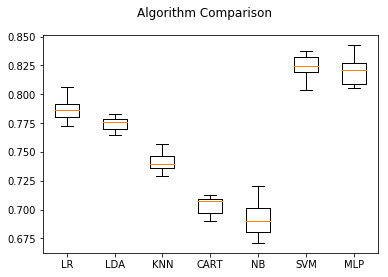

In [102]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Make predictions with chosen model on validation dataset


#### Support Vector

In [113]:
model = models[-2][1]
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#### Neural network

In [115]:
model = models[-1][1]
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

### Final accuracy analysis 


In [116]:
print("Accuracy score:\n",accuracy_score(Y_validation, predictions))
print("\n\nConfusion matrix:\n", confusion_matrix(Y_validation, predictions))
print("\n\nClassification report:\n",classification_report(Y_validation, predictions))

Accuracy score:
 0.8338861249309011


Confusion matrix:
 [[1432   33   26]
 [  91  691  258]
 [  59  134  894]]


Classification report:
               precision    recall  f1-score   support

     Chinese       0.91      0.96      0.93      1491
     English       0.81      0.66      0.73      1040
     Italian       0.76      0.82      0.79      1087

   micro avg       0.83      0.83      0.83      3618
   macro avg       0.82      0.82      0.82      3618
weighted avg       0.83      0.83      0.83      3618



### Save current model to file

In [118]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
print("Saved", model)

Saved SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Load saved model

In [120]:
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
print("Loaded", model)

Loaded SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Practical demo

In [138]:
test_string = "Test"
print("The word", test_string, "was classified as", model.predict([parse_string(test_string)]).take(0))

The word Test was classified as English
